In [1]:
%matplotlib inline
%precision 3

import numpy as np
from numpy import nan as NA
from numpy.random import randn
from numpy import corrcoef, arange
np.random.seed(123)

import pandas as pd
import os
import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from pylab import pcolor, show, colorbar, xticks, yticks
from matplotlib.ticker import PercentFormatter

plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10



import datetime

from numpy import nan as NA

#### Data loading & Reading

In [2]:
!head NCDB_1999_to_2014.csv

In [3]:
#Load data in to a dataframe
accident=pd.read_csv('NCDB_1999_to_2014.csv', engine='python')

In [4]:
#Replace all column heads to lower case
accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,01,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,01,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
5860401,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


In [5]:
#Sorth the values of the selected columns (ascending)
accident=accident.sort_values(['c_year','c_mnth','c_wday','c_hour'], ascending = True)

In [6]:
#Copy of the dataset
data=accident[:]

#Convert any non-numeric value to np.Nan (I applied these to the columns I'm using for my analysis)
data[['c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']] = data[['c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']].replace('^([A-Za-z])+$', np.nan, regex=True)
data = data.dropna()

In [7]:
#Slice the columns for my section of the data analysis
df = data.loc[:,['c_year','c_mnth','c_wday','c_hour','c_sev','c_vehs','c_conf','p_psn','p_safe']]

In [8]:
#This process is to eliminate the '0' preceding a single digit number. ex. 01 --> 1, converting str objects to int
df[['c_vehs','c_conf','p_safe']] = df[['c_vehs','c_conf','p_safe']].fillna(-1).astype(int)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,p_psn,p_safe
51,1999,01,1,00,2,1,1,11,2
596,1999,01,1,00,2,1,6,11,1
597,1999,01,1,00,2,1,6,13,1
610,1999,01,1,00,2,2,41,11,2
611,1999,01,1,00,2,2,41,13,2
...,...,...,...,...,...,...,...,...,...
5859898,2014,12,7,23,2,2,21,11,1
5859899,2014,12,7,23,2,2,21,11,2
5860177,2014,12,7,23,2,1,33,11,9
5860229,2014,12,7,23,2,1,4,11,2


In [9]:
#Generate the date-time column "date"
df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')
#df=df.set_index('date')

#### 1.1 Number of Vehicles involved in collision & Time relation

In [10]:
#Number of vehicles invovled in collision over time
df1 = df.loc[:,['date','c_vehs']]

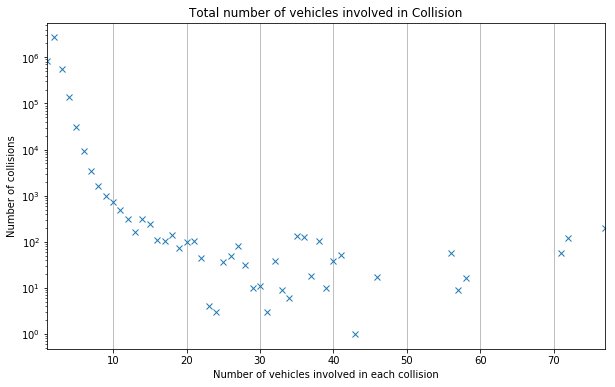

In [11]:
#Total number of vehicles involved in collision 
df2=df1.groupby('c_vehs').size().sort_index()
df2.plot(style='x',logy=True, figsize=(10,6),title='Total number of vehicles involved in Collision')
plt.grid(axis='x');
plt.xlabel('Number of vehicles involved in each collision')
plt.ylabel('Number of collisions');

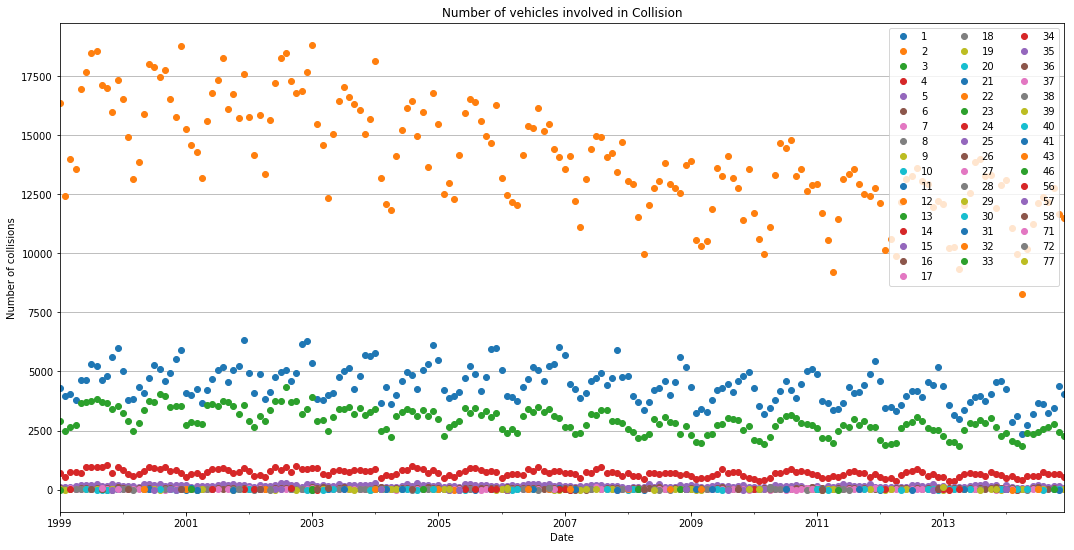

In [12]:
#Visualize the result
vehs=df1.groupby(['date','c_vehs']).size().unstack()
vehs.iloc[:].plot(style = 'o', figsize=(18,9), title = 'Number of vehicles involved in Collision')
plt.grid(axis='y')
plt.xlabel('Date')
plt.legend(ncol=3)
plt.ylabel('Number of collisions'); 

From the graph above, we can see that over time the most frequent number of vehicles involved in collisions is 2 vehicles. Since it was hard to view the results in detail, I decided to slice the data with the top 5 number of vehicles involved in collision: c_vehs= 1-5, to view the pattern better. 

Text(0,0.5,'Number of collisions')

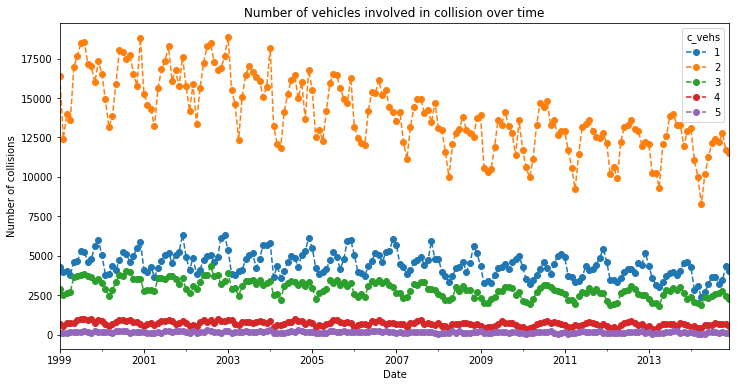

In [60]:
#Selected c_vehs 1-5 to view the top 5 most frequent number of vehicles involved in collisions 
a=vehs.iloc[:,0:5]
a.plot(style='o--',title='Number of vehicles involved in collision over time',figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Number of collisions')


Text(0,0.5,'Weekday')

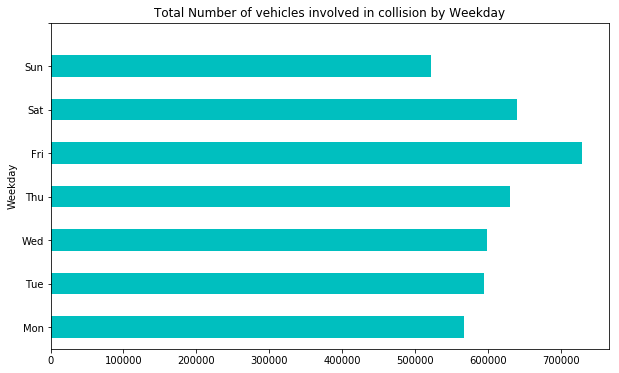

In [15]:
#Total number of vehicles involved in collision in regards to weekday
df3 = df.loc[:,['c_wday','c_vehs']]
weekday=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
w_day= df3.groupby('c_wday')['c_vehs'].size()

#Visualize the result
w_day.plot(kind='barh', color='c',figsize=(10,6),rot =0, title='Total Number of vehicles involved in collision by Weekday')
plt.yticks(range(0,8),weekday)
plt.ylabel('Weekday')

Text(0,0.5,'Number of collisions')

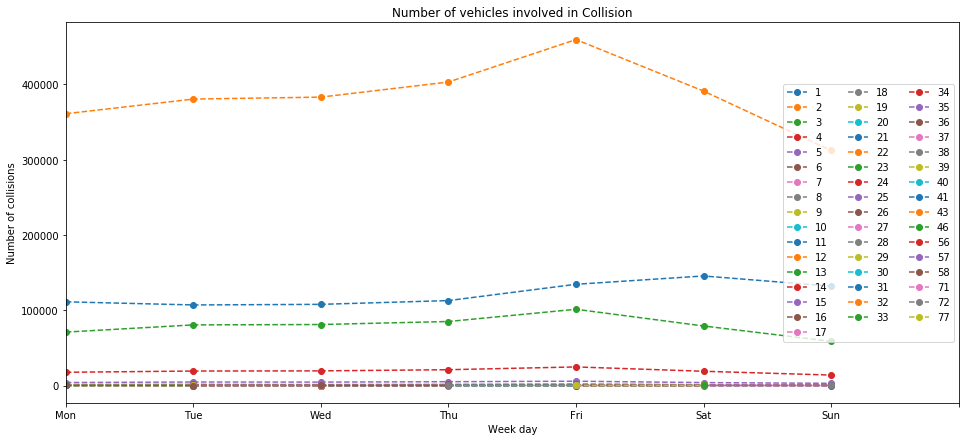

In [16]:
#Relationship of number of vehicles involved in collision (1-57 vehicles) on a specific weekday 
w_day1=df3.groupby(['c_wday','c_vehs']).size().unstack()
w_day1
w_day1.iloc[:].plot(style = 'o--', figsize=(16,7), title = 'Number of vehicles involved in Collision')
plt.legend(ncol=3,loc=7)
plt.xticks(range(0,8),weekday)
plt.xlabel('Week day')
plt.ylabel('Number of collisions')

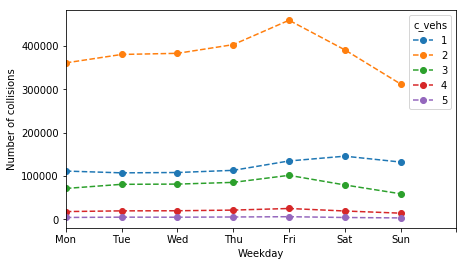

In [62]:
b=w_day1.iloc[:,0:5]
b.plot(figsize=(7,4),style='o--')
plt.xlabel('Weekday')
plt.ylabel('Number of collisions')
plt.xticks(range(0,8),weekday);

From the graph above, we can see that the most frequent number of vehicles involved in collisions over week day was 2 vehicles followed by 1 and 3 vehicles involved in collisions. Over the week days, it seems that the number of collisions increase from Thursday and peak on Friday and start declining towards Sunday. 

In [18]:
# Slice the data with just Number of vehicles involved in collision & hour
df4= df.loc[:,['c_hour','c_vehs']]
df4

,c_hour,c_vehs
51,00,1
596,00,1
597,00,1
610,00,2
611,00,2
...,...,...
5859898,23,2
5859899,23,2
5860177,23,1
5860229,23,1


Text(0,0.5,'Number of collisions')

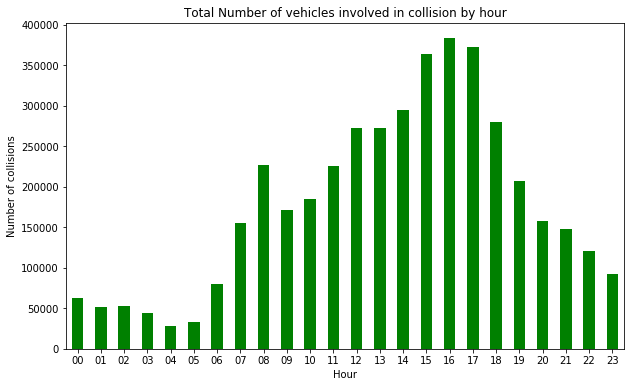

In [19]:
#Total Number of vehicles involved in collision by hour
hour=df4.groupby('c_hour')['c_vehs'].size()
hour.plot(kind='bar',title='Total Number of vehicles involved in collision by hour',color='G',rot=0)
plt.xlabel('Hour')
plt.ylabel('Number of collisions')

From the graph above, it seems that most collisions happen rush hour starting 15:00 till 17:59 and 8:00-8:59. 

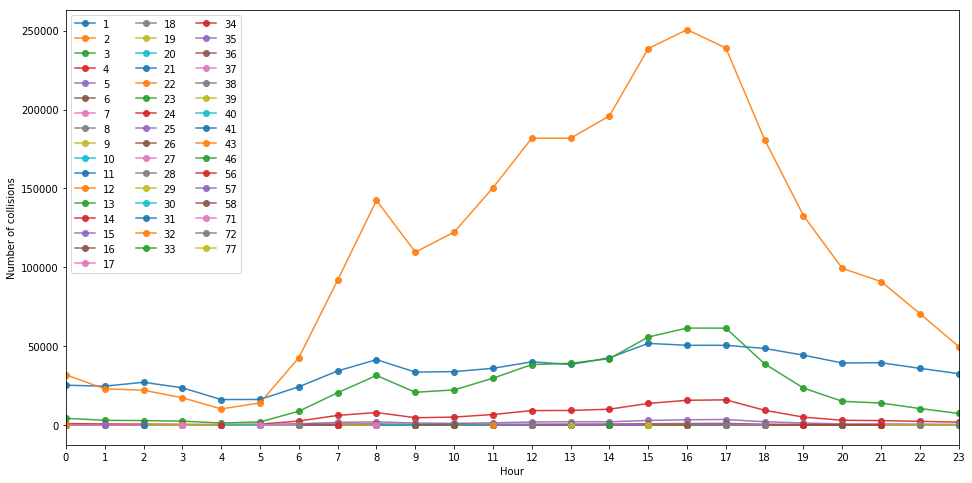

In [20]:
#Number of vehicles involved in collisions at different hours
hour1 = df4.groupby(['c_hour','c_vehs']).size().unstack()
hour1.plot(figsize=(16,8),style='o-',alpha=0.9)
plt.xticks(range(0,24),range(0,24))
plt.xlabel('Hour')
plt.ylabel('Number of collisions')
plt.legend(ncol=3)

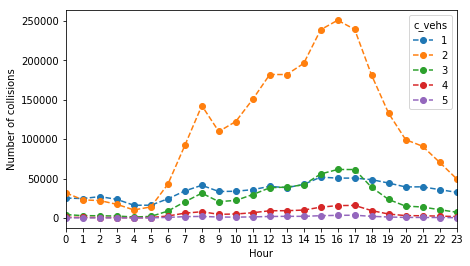

In [63]:
#Slice the data into only visualizing c_vehs=1-5 
c=hour1.iloc[:,0:5]
c.plot(style='o--',figsize=(7,4))
plt.xlabel('Hour')
plt.ylabel('Number of collisions')
plt.xticks(range(0,24),range(0,24));

#### 1.2 Number of Vehicles involved in collision & collision severity 

c_sev == 1 (fatal)
c_sev == 2 (non-fatal)

In [22]:
#Relationship between number of vehicles involved in collision and Collision severity

df5=df.loc[:,['c_vehs','c_sev']]
vehs_sev= df5.groupby(['c_vehs','c_sev']).size().unstack()
vehs_sev.index=vehs_sev.index.astype(str)
vehs_sev

c_sev,1,2
c_vehs,,
1,24399.0,826007.0
2,35495.0,2654269.0
3,6997.0,549297.0
4,2091.0,132512.0
5,619.0,30077.0
...,...,...
57,NaN,9.0
58,NaN,16.0
71,57.0,NaN


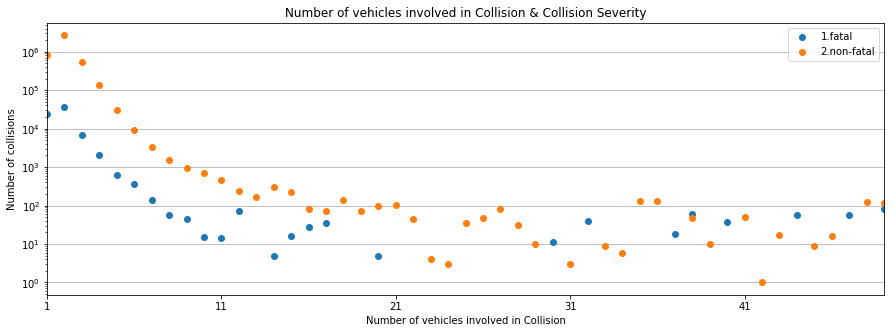

In [23]:
#Plot the new dataframe in logarithm, since the gap between numbers are huge.
vehs_sev.plot(logy=True,style = 'o', figsize=(15,5), title = 'Number of vehicles involved in Collision & Collision Severity')
plt.grid(axis='y')
plt.legend(['1.fatal','2.non-fatal'])
plt.xlabel('Number of vehicles involved in Collision') 
plt.ylabel('Number of collisions');


#### 1.3 Number of vehicles involved in collision & Collision configuration

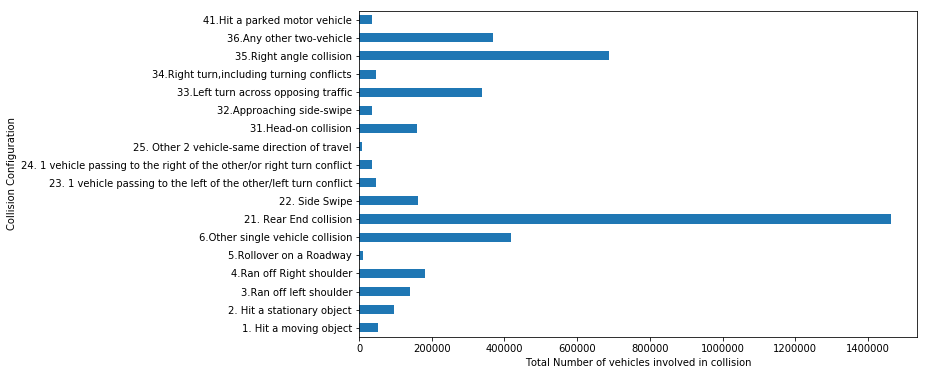

In [24]:
#Total Number of vehicles involved in collision & Collision configuration
conf=['1. Hit a moving object','2. Hit a stationary object', '3.Ran off left shoulder','4.Ran off Right shoulder','5.Rollover on a Roadway',
      '6.Other single vehicle collision', '21. Rear End collision', '22. Side Swipe','23. 1 vehicle passing to the left of the other/left turn conflict',
      '24. 1 vehicle passing to the right of the other/or right turn conflict','25. Other 2 vehicle-same direction of travel',
      '31.Head-on collision','32.Approaching side-swipe','33.Left turn across opposing traffic','34.Right turn,including turning conflicts',
      '35.Right angle collision','36.Any other two-vehicle','41.Hit a parked motor vehicle']
vehs_conf=df.groupby('c_conf')['c_vehs'].count().sort_index(ascending=True)
vehs_conf
vehs_conf.plot(figsize=(10,6), kind='barh', rot=0)
plt.xlabel('Total Number of vehicles involved in collision')
plt.ylabel('Collision Configuration')
plt.yticks(np.arange(0,18),conf);

In [25]:
#Number of vehicles involved in each collision configuration
df6 = df.loc[:,['c_vehs','c_conf']].groupby(['c_vehs','c_conf']).size().unstack().T.fillna(0)
df6.index = df6.index.astype(str)
df6

c_vehs,1,2,3,4,5,6,7,8,9,10,...,40,41,43,46,56,57,58,71,72,77
c_conf,,,,,,,,,,,,,,,,,,,,,
1,48780.0,3772.0,589.0,136.0,75.0,12.0,0.0,14.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,93330.0,1458.0,361.0,53.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,133237.0,5365.0,1252.0,393.0,87.0,39.0,35.0,2.0,1.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,175380.0,4201.0,723.0,215.0,54.0,30.0,45.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,10418.0,32.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,4221.0,295085.0,32865.0,4182.0,702.0,202.0,45.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,1570.0,40272.0,4282.0,666.0,77.0,10.0,5.0,0.0,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,5056.0,604415.0,65289.0,9753.0,1671.0,263.0,118.0,28.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


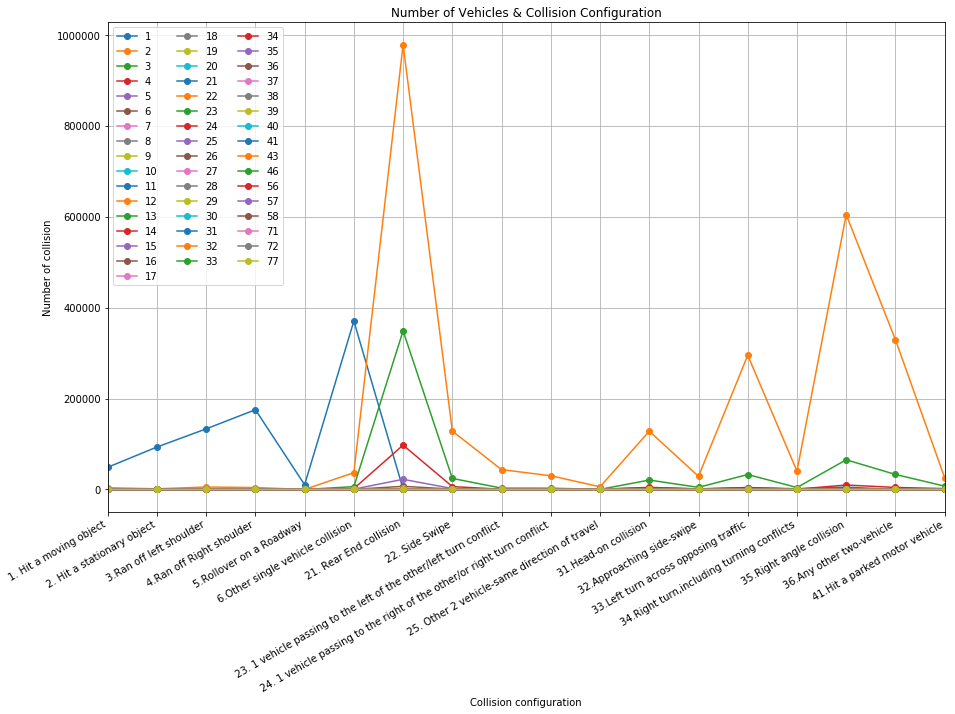

In [26]:
#Visualize the result
df6.plot(style = 'o-',figsize =(15,9),title='Number of Vehicles & Collision Configuration')
plt.xticks(np.arange(0,18),conf,rotation=30,ha='right')
plt.grid()
plt.xlabel('Collision configuration')
plt.ylabel('Number of collision')
plt.legend(ncol=3)

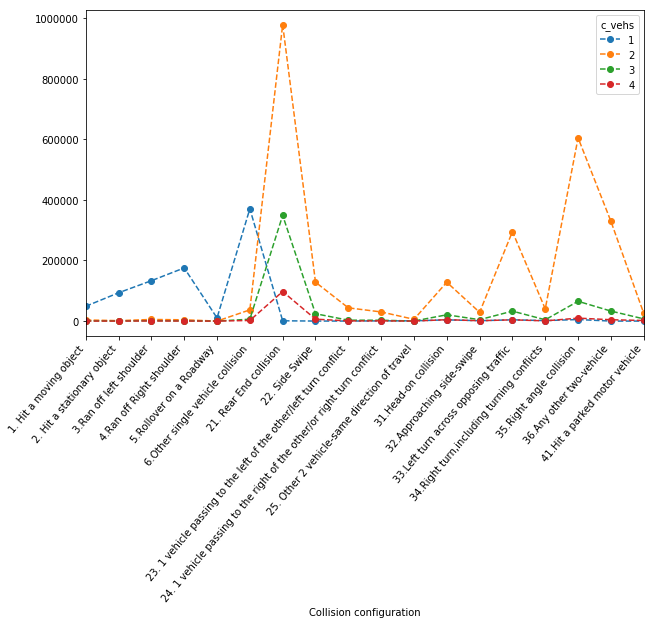

In [27]:
#Select 1-4 number of vehicles involved in collision to visualize its relationship with collision configuration
d=df6.iloc[:,0:4]
d.plot(style='o--')
plt.xlabel('Collision configuration')
plt.xticks(np.arange(0,18),conf,rotation=50,ha='right');

#### 2.1 Collision configuration & Date

In [28]:
#Analyze the relationship between collision configuration over date
df7 = df.loc[:,['date','c_conf']]
configuration=df7.groupby(['date','c_conf']).size().unstack()
configuration

c_conf,1,2,3,4,5,6,21,22,23,24,25,31,32,33,34,35,36,41
date,,,,,,,,,,,,,,,,,,
1999-01,2546,317,777,862,34,319,7550,1306,165,162,21,1672,227,3608,2336,2430,57,113
1999-02,2065,295,664,794,72,305,6317,637,195,104,11,1015,167,3102,1641,2053,33,99
1999-03,2209,273,633,800,57,375,7476,857,141,119,12,963,129,3405,1802,2275,55,90
1999-04,2170,198,657,721,53,310,7013,706,216,205,7,647,152,3666,2106,2063,59,87
1999-05,2693,201,735,904,55,417,9325,748,278,203,18,695,200,4689,2252,2712,56,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08,93,461,651,893,55,1577,7000,757,257,234,26,580,217,1397,86,3090,2027,174
2014-09,96,451,504,704,47,1573,7099,619,260,187,51,506,135,1450,118,2860,2137,140
2014-10,104,521,535,651,36,1727,7259,715,187,171,39,491,133,1614,105,3264,2162,171


Text(0,0.5,'Number of collision')

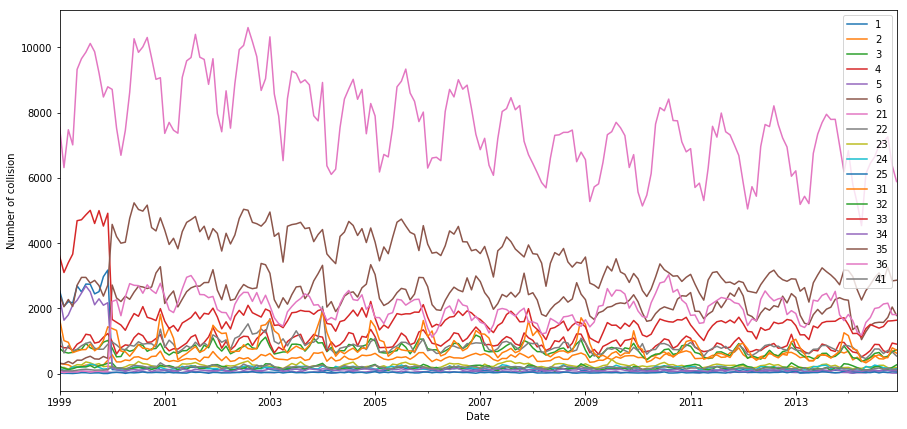

In [29]:
configuration.plot(style='',figsize=(15,7))
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Number of collision')

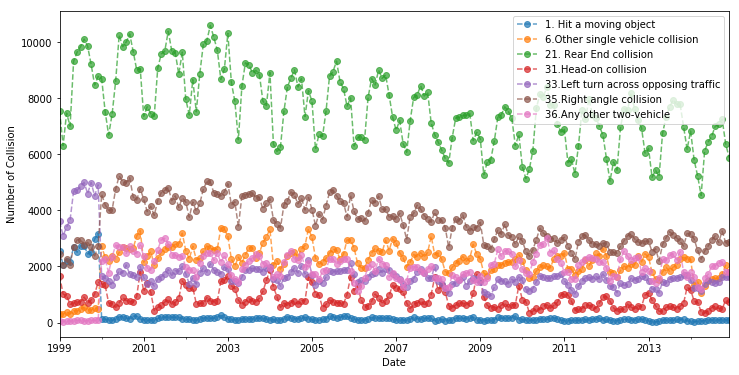

In [50]:
#Select top 5 frequest configuration collision and plot the data
confi=['1. Hit a moving object','6.Other single vehicle collision', '21. Rear End collision','31.Head-on collision',
       '33.Left turn across opposing traffic',
      '35.Right angle collision','36.Any other two-vehicle']
e=configuration[[1,6,21,31,33,35,36]]
e.plot(figsize=(12,6),style='o--',alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Collision')
plt.legend(confi)

#### 2.2 Collision configuration & Collision severity

In [34]:
#Analyze the relationship between collision configuration and collision severity
df8 = df.loc[:,['c_conf','c_sev']]
conf_sev= df8.groupby(['c_conf','c_sev']).size().unstack()
conf_sev.index= conf_sev.index.astype(str)
conf_sev

c_sev,1,2
c_conf,,
1,1388,52009
2,2454,92750
3,5384,135072
4,6118,174533
5,266,10189
...,...,...
33,3420,333933
34,560,46346
35,9490,677180


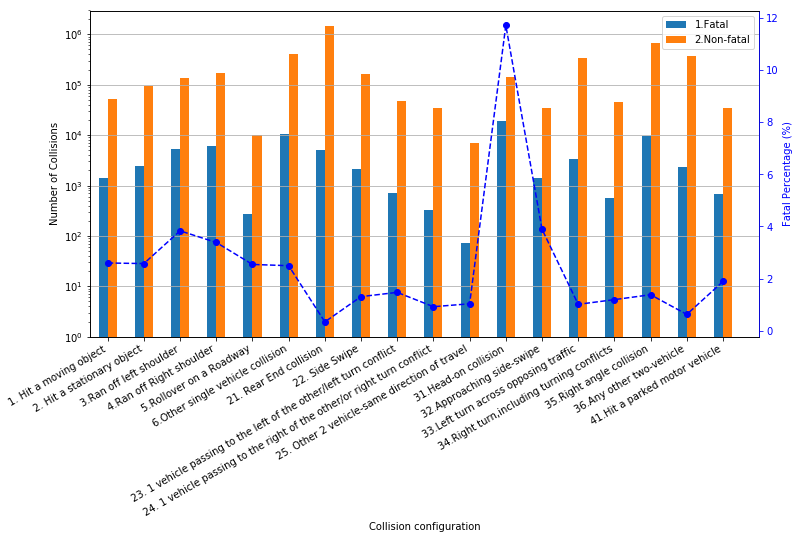

In [64]:
#Visualize the results
#conf_sev.plot(kind='bar',log=True,style = 'o-', figsize=(10,6), title = 'Number of vehicles involved in Collision & Collision Severity')
#plt.grid()
#plt.legend(['1.fatal','2.non-fatal'])
#plt.xlabel('Collision configuration') 
#plt.ylabel('Number of collisions')
#plt.xticks(np.arange(0,18),conf,rotation=50,ha='right');

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

conf_sev.plot(kind='bar',rot=30,log=True,style='o--',figsize=(12,6),ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Collision configuration')
ax1.set_xticklabels(conf,ha='right')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

se1 = conf_sev[1]/(conf_sev[1]+conf_sev[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')
plt.xticks(np.arange(0,18),conf,rotation=50,ha='right');
plt.xlim(-0.5,18.);





#### 3.1 Person Position & severity

In [41]:
#Analyze the relationship between person position and collision severity
position=['11.Driver','12. Front row, center','13.Front row: right outboard','21.Second row:left outboard','22.Second row:center','23.Second row:right outboard',
          '31.Third row:left outboard','32.Third row:center','33.Third row:right outboard','96.Unknown occupant','97.Sitting on someone’s lap','98.Outside passenger compartment','99.Pedestrian']
df9=df.loc[:,['p_psn','c_sev']]
psn_sev= df9.groupby(['p_psn','c_sev']).size().unstack()
psn_sev

c_sev,1,2
p_psn,,
11,41372,2739810
12,1443,68275
13,13486,763592
21,3638,183804
22,1693,76943
...,...,...
33,107,5028
96,1434,27235
97,12,156


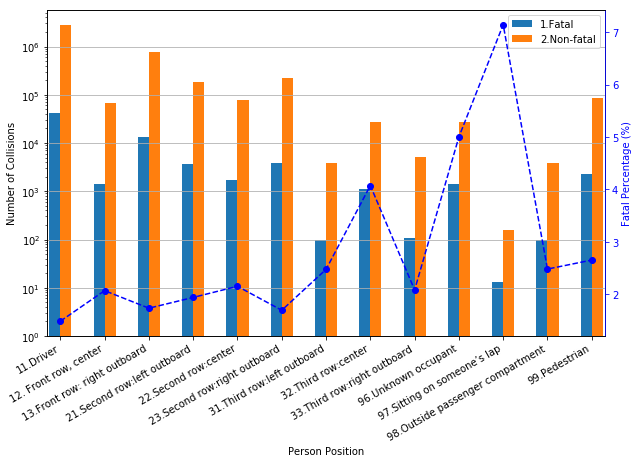

In [42]:
#Visualize the result
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

psn_sev.plot(kind='bar',rot=30,log=True,style='o--',figsize=(10,6),ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Person Position')
ax1.set_xticklabels(position,ha='right')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

se1 = psn_sev[1]/(psn_sev[1]+psn_sev[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')
plt.xticks(np.arange(0,13),position,rotation=40,ha='right')
plt.xlim(-0.3,12.3);




#### 3.2 Person position & configuration 

In [43]:
#Relationship between Person position and collision configuration
df10=df.loc[:,['p_psn','c_conf']]
psn_conf= df10.groupby(['p_psn','c_conf']).size().unstack().T.fillna(0)
psn_conf.index=psn_conf.index.astype(str)
psn_conf

p_psn,11,12,13,21,22,23,31,32,33,96,97,98,99
c_conf,,,,,,,,,,,,,
1,27522.0,878.0,8067.0,1909.0,824.0,2149.0,39.0,498.0,60.0,276.0,1.0,50.0,11124.0
2,67842.0,1188.0,16182.0,3369.0,1232.0,4270.0,33.0,28.0,41.0,498.0,3.0,101.0,417.0
3,88376.0,3893.0,27472.0,6745.0,3017.0,7657.0,233.0,593.0,263.0,2015.0,4.0,111.0,77.0
4,115161.0,5138.0,34103.0,8434.0,3757.0,9383.0,277.0,761.0,323.0,3036.0,2.0,169.0,107.0
5,7049.0,141.0,1839.0,506.0,216.0,506.0,8.0,7.0,10.0,114.0,2.0,30.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,224623.0,6977.0,63923.0,13805.0,5378.0,17551.0,512.0,1180.0,643.0,2514.0,0.0,139.0,108.0
34,31986.0,751.0,8565.0,1839.0,841.0,2262.0,1.0,403.0,2.0,168.0,0.0,43.0,45.0
35,457747.0,11976.0,126655.0,29296.0,11948.0,36465.0,675.0,3862.0,915.0,5996.0,23.0,479.0,633.0


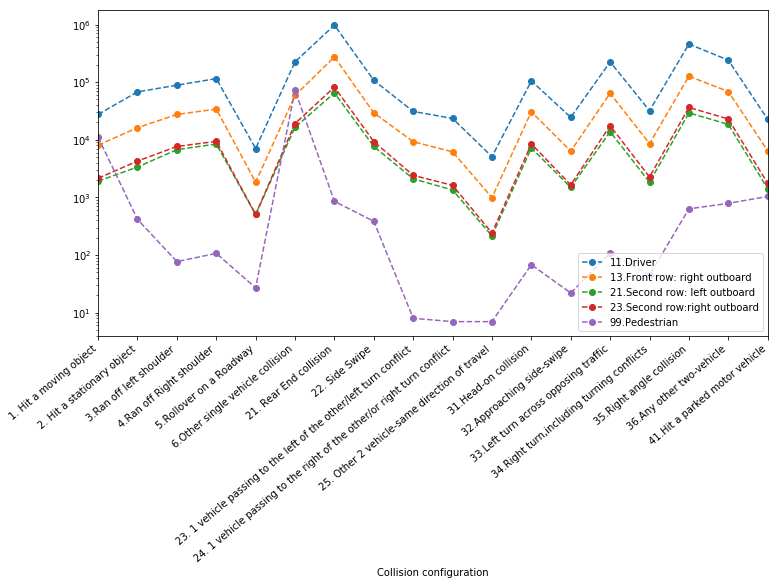

In [44]:
#Visualize the result
psn=['11.Driver','13.Front row: right outboard','21.Second row: left outboard','23.Second row:right outboard','99.Pedestrian']
f=psn_conf.iloc[:,[0,2,3,5,12]]
f.plot(logy=True,style='o--',figsize=(12,6))
plt.legend(psn)
plt.xlabel('Collision configuration')
plt.xticks(np.arange(0,18),conf,rotation=40,ha='right');

#### 4. Safety device used 

In [45]:
#Relationship between safety device used over time
df11=df.loc[:,['date','p_safe']]
saf_date= df11.groupby(['date','p_safe']).size().unstack()
saf_date

p_safe,1,2,9,10,11,12,13
date,,,,,,,
1999-01,1101.0,22557.0,84.0,NaN,NaN,37.0,723.0
1999-02,1050.0,17809.0,65.0,2.0,NaN,25.0,618.0
1999-03,1182.0,19627.0,99.0,NaN,NaN,44.0,719.0
1999-04,1228.0,18569.0,267.0,NaN,NaN,26.0,946.0
1999-05,1449.0,22720.0,492.0,1.0,NaN,33.0,1592.0
...,...,...,...,...,...,...,...
2014-08,775.0,16983.0,1208.0,NaN,NaN,309.0,300.0
2014-09,688.0,16833.0,875.0,NaN,NaN,255.0,286.0
2014-10,729.0,18107.0,473.0,1.0,NaN,321.0,254.0


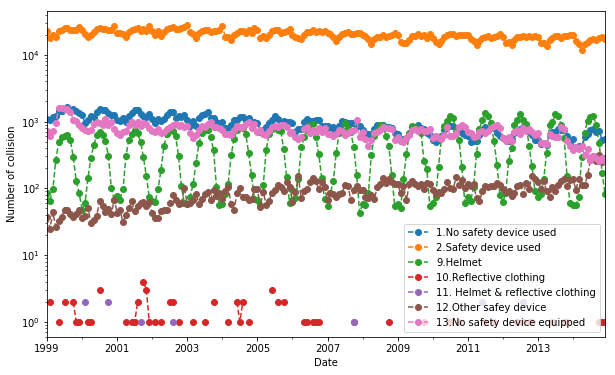

In [46]:
#Visualize the result
#13. No safety device equipped => eg. buses
safety=['1.No safety device used','2.Safety device used','9.Helmet',
        '10.Reflective clothing','11. Helmet & reflective clothing','12.Other safey device','13.No safety device equipped']

saf_date.plot(logy=True, style='o--',figsize=(10,6))
plt.legend(safety, loc=4)
plt.ylabel('Number of collision')
plt.xlabel('Date');

In [47]:
#Relationship between safety device used and collision severity
df12=df.loc[:,['p_safe','c_sev']]
saf_sev=df12.groupby(['p_safe','c_sev']).size().unstack().fillna(0)
saf_sev.index=saf_sev.index.astype(str)
saf_sev

c_sev,1,2
p_safe,,
1,14791.0,159975.0
2,48835.0,3816516.0
9,2657.0,80146.0
10,1.0,73.0
11,0.0,11.0
12,612.0,17003.0
13,3848.0,136992.0


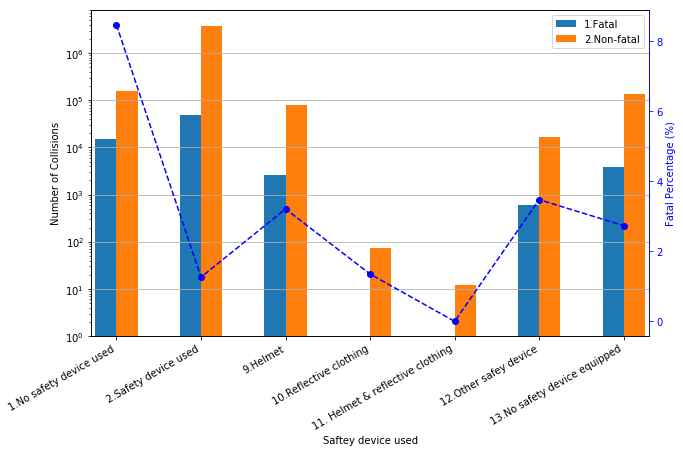

In [48]:
#Visualize the result
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

saf_sev.plot(kind='bar',rot=30,log=True,style='o--',figsize=(10,6),ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Saftey device used')
ax1.set_xticklabels(safety,ha='right')
ax1.grid(axis='y')
ax1.legend(['1.Fatal','2.Non-fatal'])

se1 = saf_sev[1]/(saf_sev[1]+saf_sev[2])*100
se1.plot(c='b', style='o--', ax=ax2)
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')
plt.xticks(range(0,7),safety)
plt.xlim(-0.3,6.3);